In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
fpt = pd.read_csv('/content/drive/MyDrive/Stock_analysis/FPT.csv')
fpt.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Date/Time      97406 non-null  object 
 2   Open           97406 non-null  float64
 3   High           97406 non-null  float64
 4   Low            97406 non-null  float64
 5   Close          97406 non-null  float64
 6   Volume         97406 non-null  int64  
 7   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.9+ MB


In [ ]:
fpt.rename(columns={
    'Date/Time':'Date',
}, inplace=True)

In [ ]:
fpt['Date'] = pd.to_datetime(fpt['Date'])
fpt.set_index('Date', inplace = True)

# 15 minues '15T', hour 'H', Day 'D'
fpt = fpt.resample('15T').agg({
    'High': 'max',  # Lấy giá trị cao nhất
    'Low': 'min',   # Lấy giá trị thấp nhất
    'Open': 'first', # Lấy giá trị mở cửa đầu tiên
    'Close': 'last', # Lấy giá trị đóng cửa cuối cùng
    'Volume': 'sum'  # Tính tổng khối lượng giao dịch
}).dropna()

In [ ]:
fpt

,High,Low,Open,Close,Volume
Date,,,,,
2018-12-25 09:15:00,30.89,30.59,30.89,30.66,84960
2018-12-26 09:15:00,31.22,31.04,31.04,31.22,13670
2018-12-26 09:30:00,31.11,30.89,31.11,30.96,22420
2018-12-26 09:45:00,31.19,30.89,30.89,31.11,13860
2018-12-26 10:00:00,31.19,31.11,31.19,31.11,36720
...,...,...,...,...,...
2020-12-22 13:30:00,57.60,57.50,57.50,57.60,153140
2020-12-22 13:45:00,58.00,57.50,57.50,58.00,560700
2020-12-22 14:00:00,58.50,58.00,58.00,58.20,493510


In [ ]:
print(f'Dataframe contains stock prices between {fpt.index.min()} {fpt.index.max()}')
print(f'Total number of days: {(fpt.index.max() - fpt.index.min()).days} ')

Dataframe contains stock prices between 2018-12-25 09:15:00 2020-12-22 14:45:00
Total number of days: 728 


In [ ]:
fpt.describe()

,High,Low,Open,Close,Volume
count,8012.000000,8012.000000,8012.000000,8012.000000,8.012000e+03
mean,44.479978,44.299799,44.390357,44.392977,9.779714e+04
std,6.763114,6.727135,6.745880,6.744900,1.096750e+05
min,30.290000,30.220000,30.290000,30.250000,1.000000e+01
25%,38.360000,38.157500,38.280000,38.270000,3.630750e+04
50%,46.650000,46.450000,46.550000,46.550000,6.746000e+04
75%,49.170000,48.910000,49.080000,49.050000,1.204650e+05
max,58.500000,58.100000,58.100000,58.200000,1.920350e+06


<Axes: >

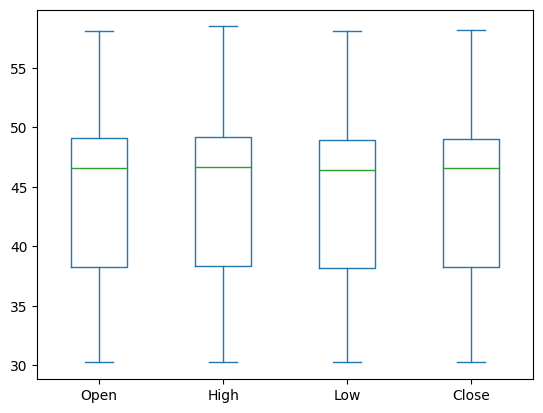

In [ ]:
fpt[['Open', 'High', 'Low', 'Close']].plot(kind ='box')

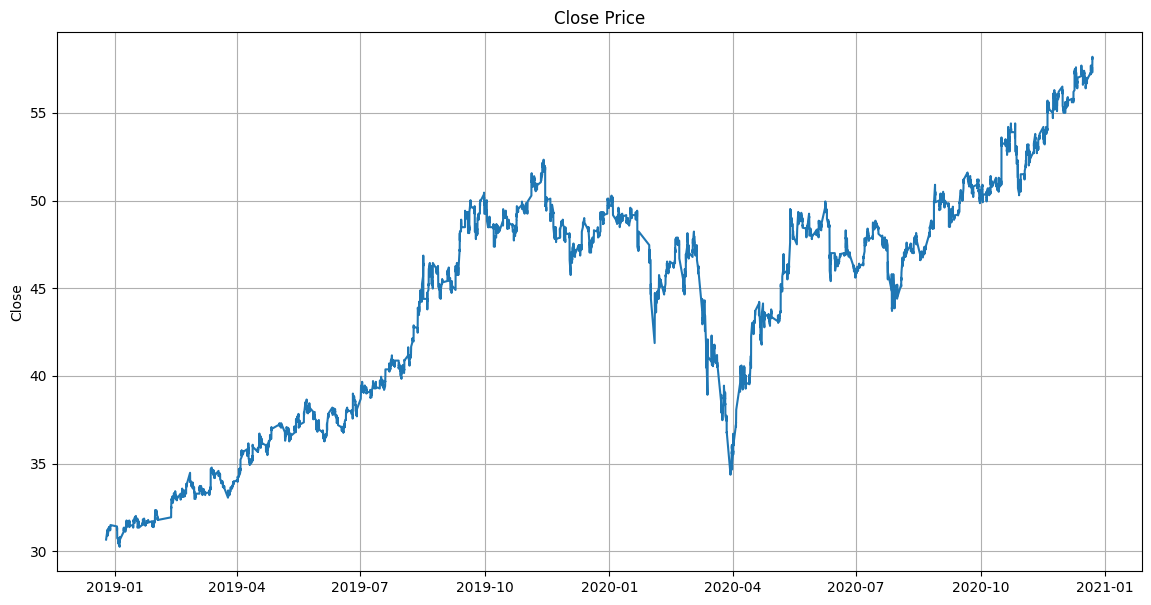

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(fpt['Close'])
plt.ylabel('Close')
plt.title("Close Price")
plt.grid()

In [ ]:
fpt["Future"] = fpt["Close"].shift(-1)

fpt['Target'] = (fpt['Future'] > fpt['Close']).astype(int)

In [ ]:
# Thêm các đặc trưng trung bình di động
fpt['MA10'] = fpt['Close'].rolling(window=10).mean()
fpt['MA50'] = fpt['Close'].rolling(window=50).mean()
fpt['MA100'] = fpt['Close'].rolling(window=100).mean()

# Loại bỏ các giá trị NaN sau khi tạo các đặc trưng trung bình di động
fpt.dropna(inplace=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score

# Chọn các đặc trưng và target
predictors = ["Close", "Open", "High", "Low", "Volume"]
X = fpt[predictors]
y = fpt['Target']

# Chia dữ liệu thành train và test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Thiết lập Grid Search cho RandomForest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'min_samples_split': [2, 5, 10],
    'random_state': [1]
}
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, scoring='precision', cv=5)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

# Thiết lập Grid Search cho XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'random_state': [1]
}
grid_xgb = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid_xgb, scoring='precision', cv=5)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_

# Kết hợp các mô hình con bằng Voting Classifier
voting_clf = VotingClassifier(estimators=[('rf', best_rf), ('xgb', best_xgb)], voting='hard')
voting_clf.fit(X_train, y_train)

# Đánh giá độ chính xác của Voting Classifier trên tập kiểm tra
preds = voting_clf.predict(X_test)
precision = precision_score(y_test, preds)
print(f'Precision: {precision}')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.32231404958677684


In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Huấn luyện mô hình RandomForest
model = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=1)
model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

precision = precision_score(y_test, y_pred)
print(f'Precision: {precision}')

Precision: 0.3767123287671233


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

predictors = ["Close", "Open", "High", "Low", "Volume", "MA10", "MA50", "MA100"]

X = fpt[predictors]
y = fpt['Target']
selector = SelectKBest(f_classif, k=5)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]


model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = fpt.iloc[:int(.80*len(fpt)), :]
test = fpt.iloc[int(.80*len(fpt)):, :]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5

<Axes: xlabel='Date'>

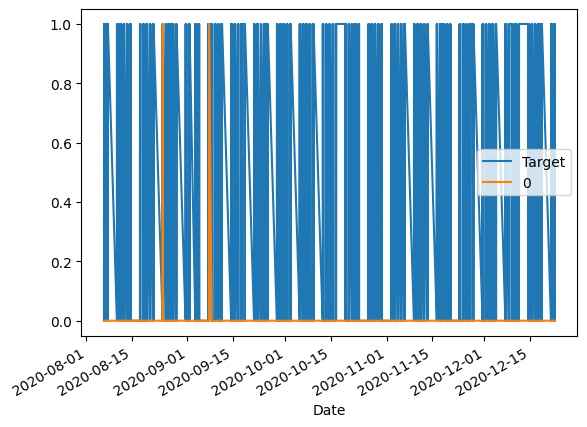

In [ ]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [ ]:
fpt.head()

,Open,High,Low,Close,Volume,Future,Target,DayOfWeek,Hour,Minute,MA10,MA50,MA100
Date,,,,,,,,,,,,,
2018-12-28 10:00:00,31.26,31.26,31.26,31.26,190.0,31.26,0,4,10,0,31.262,31.3176,31.1850
2018-12-28 10:05:00,31.26,31.26,31.26,31.26,1920.0,31.30,1,4,10,5,31.254,31.3160,31.1887
2018-12-28 10:10:00,31.30,31.30,31.30,31.30,10.0,31.30,0,4,10,10,31.250,31.3152,31.1943
2018-12-28 10:15:00,31.30,31.30,31.30,31.30,5000.0,31.26,0,4,10,15,31.250,31.3144,31.1962
2018-12-28 10:20:00,31.26,31.26,31.26,31.26,600.0,31.30,1,4,10,20,31.246,31.3144,31.1977


In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=2000, step=200):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(fpt, model, predictors)

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.39762611275964393

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
0    0.694047
1    0.305953
Name: count, dtype: float64

In [ ]:
import xgboost as xgb
model1 = xgb.XGBRegressor()
model1.fit(train[predictors], train["Target"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
from sklearn.metrics import precision_score

predXgb = model1.predict(test[predictors])
predXgb = pd.Series(preds, index=test.index)
precision_score(test["Target"], predXgb)

0.6666666666666666